In [2]:
#@title
"""Import everything we need"""
already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==1.0.1
    !pip install mat73
    !pip install tqdm

import os
import random
import mat73
import scipy.io
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
from tensorflow.math import abs, angle, real, imag, subtract, multiply
from scipy.optimize import minimize
from matplotlib import colors
from cycler import cycler
from google.colab import drive
from tqdm import tqdm

In [3]:
#@title
"""Import the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape=[64,64]):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

In [4]:
def extract_pos_and_images(data):
    """Saves images and positions for individual particles."""
    particles_timeseries = []
    particles_positions = []
    num_particles = data.shape[1]

    for i in tqdm(range(num_particles)):
        positions = data[0,i][0,0]["Positions"][:,1:4]
        particles_positions.append(positions)
        roi_data = np.array(data[0,i][0,0]["ROI"])

        timeseries = []
        for j in range(roi_data[0,0].shape[0]):
            particleROI = np.expand_dims(np.fft.fftshift(np.fft.ifft2(exp_expand(roi_data[0,0][j,:]))), axis = -1)
            timeseries.append(particleROI)
        particles_timeseries.append(np.array(timeseries))
    return particles_positions, particles_timeseries

In [5]:
def create_group(crop_size=64, padding=16, wavelength=525e-9, pixel_size=114e-9):
    crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size, wavelength)
    crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size, wavelength)

    args = dt.Arguments(
        translate=lambda: np.random.randn(2)*0.5,
        rotate=lambda: np.random.uniform(0, np.pi*2),
        z=lambda: np.random.randn(1)*5,
    )

    group = ( 
        dt.Affine(rotate=args.rotate) 
        >> dt.Affine(translate=args.translate) 
        >> dt.FourierTransform(padding=padding) 
        >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z, padding=padding) 
        >> dt.InverseFourierTransform(padding=padding) 
    )

    equivariance = (
        dt.models.lodestar.Rotational2DEquivariance(args.rotate)
        >> dt.models.lodestar.TranslationalEquivariance(args.translate)
        >> dt.models.lodestar.Equivariance(1, args.z/10, indexes=2)
    )

    return group, equivariance

def create_training_set(particles_timeseries):
    imgs = []
    for particle_id in range(0,len(particles_timeseries),1):
        img = np.stack((np.real(particles_timeseries[particle_id])[:,:,:,0], np.imag(particles_timeseries[particle_id][:,:,:,0])), axis=-1)
        img = img[0,:,:,:]
        imgs.append(img)
    return dt.Value(lambda: random.choice(np.array(imgs)))

def plot_dataset(dataset, group, nrows=3, ncols=10):
    for _ in range(nrows):
        fig, axs = plt.subplots(1,ncols,figsize=(25,8))
        for i in range(ncols):
          axs[i].imshow((dataset>>group).update()()[..., 1])
        plt.show()


In [6]:
"""Create custom layers"""
class CustomLayer(keras.layers.Layer):
    "Takes 2 layers as input and outputs 4 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)


In [7]:
"""Create models"""
def create_model(custom_layer, num_layers, image_size, num_outputs):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(image_size,image_size,2)))
    model.add(custom_layer)
    model.add(keras.layers.Conv2D(64, 3, activation='relu', strides=(2,2)))
    for _ in range(num_layers):
        model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(num_outputs+1,1))
    
    model = dt.models.LodeSTAR(model=model, input_shape=(None, None, 2), num_outputs=num_outputs)
    model.specs = {"Layers": num_layers}
    model.totalhistory = {"total_loss":[], "consistency_loss":[]}
    model.compile(loss=["mae", "mae", "mae"], optimizer=tf.keras.optimizers.Adam(), loss_weights=[1, 1, 1])
    return model


In [8]:
def save_progress(model, h):
    model.totalhistory["total_loss"].extend(h.history["total_loss"])
    model.totalhistory["consistency_loss"].extend(h.history["consistency_loss"])

def plot_progress(models):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    cc = cycler(color=list('bgrcmyk'))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
    ax1.set_prop_cycle(cc)
    ax2.set_prop_cycle(cc)

    for i, model in enumerate(models):
        ax1.plot(moving_average(model.totalhistory["total_loss"], 10), label=f"{model.specs}")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Total Loss")
        ax1.set_yscale("log")
        ax1.legend()

        ax2.plot(moving_average(model.totalhistory["consistency_loss"], 10), label=f"{model.specs}")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Consistency loss")
        ax2.set_yscale("log")
        ax2.legend()

    ax1.grid(True)
    ax2.grid(True)
    plt.show()


In [10]:
def predict_on_stack(model, val_stack):
    """returns a numpy tensor containing propagated distance as well as the prediction, for ever propagation distance and every image images"""
    try:
        dets = np.array(model.predict_and_detect(val_stack, mode="ratio"))
    except ValueError as E:
        dets = np.expand_dims(np.zeros((val_stack.shape[0],3)), axis=0)
        print(E)
    dets = reshape_dets(dets, val_stack.shape[2])
    return dets

def reshape_dets(dets, image_size):
    """Removes all particles but the one closest to the center. If no particles are detected, sets the value to 0."""
    out = []
    for coords in dets:
        if coords.shape != (0, 3):
            x, y = image_size//2, image_size//2
            idx = np.argmin(np.array(coords[:,:2]- np.array((x, y))), axis=0)[0]
            out.append(coords[idx,:])
        else:
            out.append([0,0,0])
    return np.array(out)

In [11]:
def calc_sigma2(arr):
    sigma2 = -np.mean(
        np.multiply(
            np.diff(arr[:-1]), 
            np.diff(arr[1:])
            ))
    return sigma2

In [12]:
def train_on_particle(model, particle, num_outputs, group, equivariance):
    training_set = create_training_set(particle)

    generator = dt.models.lodestar.LodeSTARGenerator(
        training_set,
        num_outputs=num_outputs, 
        transformation_function=(group, equivariance), 
        batch_size=8, 
        min_data_size=100, 
        max_data_size=101,
    )

    for _ in tqdm(range(10)):
        with generator:
            h = model.fit(generator, epochs=10, steps_per_epoch=100, verbose=0)

def compare_lode_matlab(model, particles, particles_positions,  verbose=1):
    z_mults = []
    traces_matlab = []
    traces_lode = []

    for particle_id in tqdm(range(len(particles))):

        timeseries = np.stack((np.real(particles[particle_id][:,:,:,0]), np.imag(particles[particle_id][:,:,:,0])), axis=-1)
        corrections = predict_on_stack(model, timeseries)

        x_lode, y_lode, z_lode = corrections[:,0], corrections[:,1], corrections[:,2]
        x_matlab, y_matlab, z_matlab = particles_positions[particle_id][:,0], particles_positions[particle_id][:,1], 1.5*particles_positions[particle_id][:,2]

        z_lode = z_lode - np.mean(z_lode)
        x_new, y_new, z_new = x_matlab+(x_lode-32)*0.114, y_matlab+(y_lode-32)*0.114, z_matlab+z_lode # byt ut mot pixel_sizez!

        z_mult = minimize(lambda x: np.abs(calc_sigma2(z_matlab + z_lode*x)), [0], method="Powell").x
        z_mult = np.median([-10,z_mult,10]) #reducing the effect of very strange values

        if verbose:
            print("PARTICLE ID:", particle_id, end="  ")
            print(f"z_mult: {z_mult:.3f}, sigma2_new/sigma2_matlab: {calc_sigma2(z_new)/calc_sigma2(z_matlab):.2f}")

            if particle_id%10==0:
                fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
                ax1.plot(x_matlab, 'b')
                ax1.plot(x_new, 'r')
                ax1.set_xlabel("x")

                ax2.plot(y_matlab, 'b')
                ax2.plot(y_new, 'r')
                ax2.set_xlabel("y")

                ax3.plot(z_matlab, 'b')
                ax3.plot(z_new, 'r')
                ax3.set_xlabel("z")
                plt.show()

        z_mults.append(z_mult)
        traces_matlab.append(np.array([x_matlab, y_matlab, z_matlab]))
        traces_lode.append(np.array([x_lode*0.114, y_lode*0.114, z_lode]))

    return traces_matlab, traces_lode, z_mults

In [13]:
def plot_diffusion(Dx, Dz, colors, title):
    range=(-2,6)
    nbins=25
    plt.figure(figsize=(5, 4))

    plt.hist(Dx, nbins, alpha=0.5, range=range, facecolor=seaborn.color_palette("colorblind")[colors[0]], label="In-plane diffusion")
    plt.hist(Dz, nbins, alpha=0.5, range=range, facecolor=seaborn.color_palette("colorblind")[colors[1]], label="Vertical diffusion")
    
    plt.axvline(np.median(Dx), c=seaborn.color_palette("colorblind")[colors[0]], linestyle="--", label="Median")
    plt.axvline(np.median(Dz), c=seaborn.color_palette("colorblind")[colors[1]], linestyle="--", label="Median")
    plt.title(title)
    plt.legend()
    plt.show()
    print(f"nz/nx = sqrt(Dz/Dx) {np.sqrt(np.median(Dz)/np.median(Dx)):.3f}")

def calculate_diffusion(traces, delta_time, shortest_trace=20):
    _traces = [trace for trace in traces if trace.shape[1]>shortest_trace]

    #Ekvation 16
    sigma_x2 = np.array([calc_sigma2(trace[0,:]) for trace in _traces])
    sigma_z2 = np.array([calc_sigma2(trace[2,:]) for trace in _traces])

    D_x, D_z = [], []
    for i, pos in enumerate(_traces):
      D_x.append((
          np.mean(np.diff(pos[0,:])**2)
          -2*sigma_x2[i])
          /(2*delta_time)
          )
      D_z.append((
          np.mean(np.diff(pos[2,:])**2)
          -2*sigma_z2[i])
          /(2*delta_time)
          )
    plot_diffusion(D_x, D_z, (9,3), "Ekvation 16, Separata skattningar för sigma")

    #Ekvation 16 (medelvärdet av sigma)
    D_x, D_z = [], []
    for i, pos in enumerate(_traces):
      D_x.append((
          np.mean(np.diff(pos[0,:])**2)
          -2*np.median(sigma_x2))
          /(2*delta_time)
          )
      D_z.append((
          np.mean(np.diff(pos[2,:])**2)
          -2*np.median(sigma_z2))
          /(2*delta_time)
          )
    plot_diffusion(D_x, D_z, (9,3), "Ekvation 16, Medelvärdet av alla sigma")

In [14]:
def save_weights(path, model):
    model.save_weights(path)

def load_weights(path, model):
    model.load_weights(path)
    return model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tue Apr  5 14:00:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   1216MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

100%|██████████| 1308/1308 [00:54<00:00, 23.92it/s]


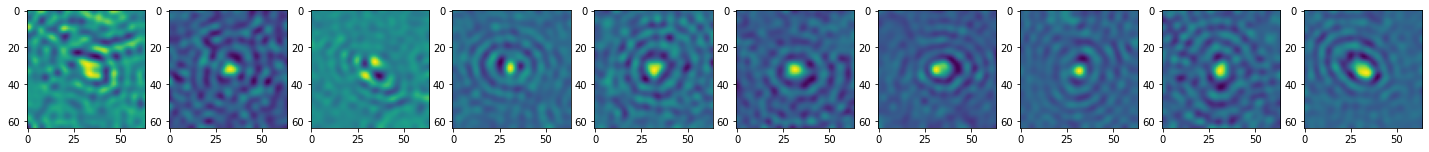

Creating corrected traces 

 14%|█▍        | 182/1308 [00:36<03:41,  5.08it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
100%|██████████| 1308/1308 [03:28<00:00,  6.28it/s]


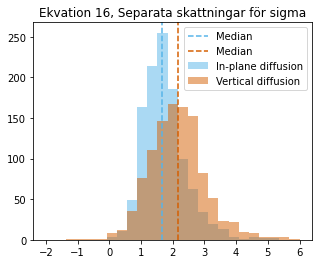

nz/nx = sqrt(Dz/Dx) 1.136


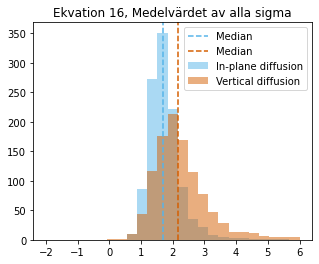

nz/nx = sqrt(Dz/Dx) 1.132
Förväntat förhållande: 1.125
Loading file:
 0wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces.mat 

100%|██████████| 239/239 [00:09<00:00, 24.24it/s]


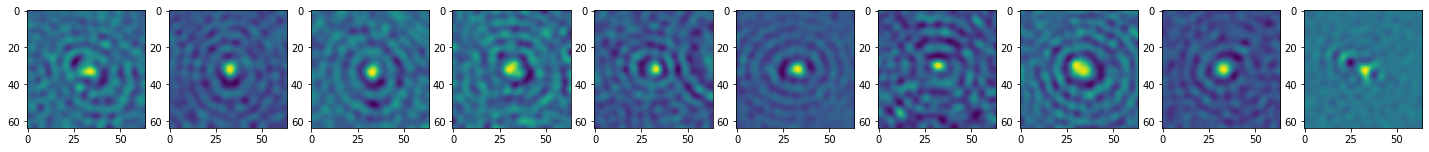

Creating corrected traces 

100%|██████████| 239/239 [00:36<00:00,  6.54it/s]


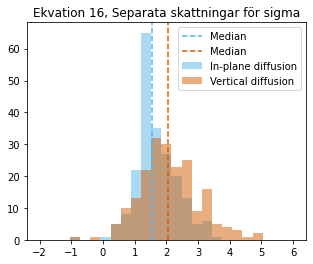

nz/nx = sqrt(Dz/Dx) 1.152


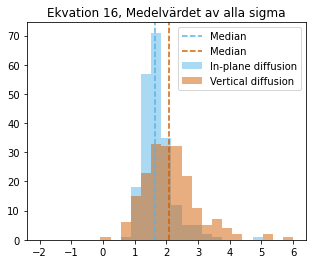

nz/nx = sqrt(Dz/Dx) 1.131
Förväntat förhållande: 1.125
Loading file:
 25wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0.mat 

100%|██████████| 1045/1045 [00:52<00:00, 20.01it/s]


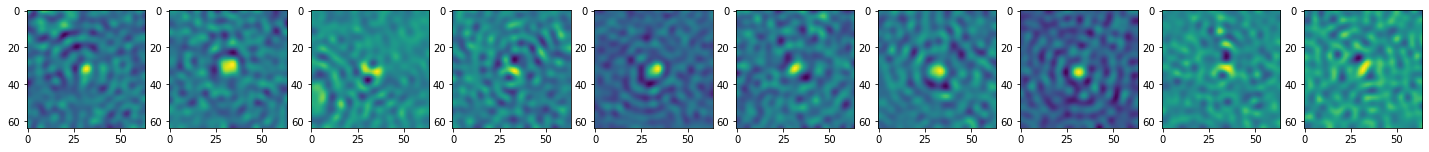

Creating corrected traces 

100%|██████████| 1045/1045 [03:04<00:00,  5.67it/s]


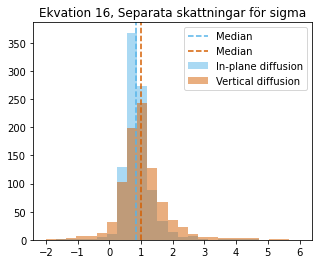

nz/nx = sqrt(Dz/Dx) 1.089


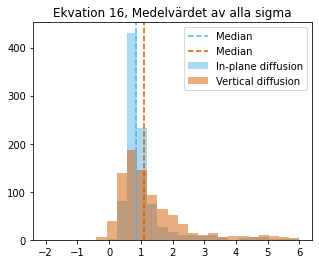

nz/nx = sqrt(Dz/Dx) 1.134
Förväntat förhållande: 1.100
Loading file:
 25wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces.mat 

100%|██████████| 120/120 [00:06<00:00, 17.94it/s]


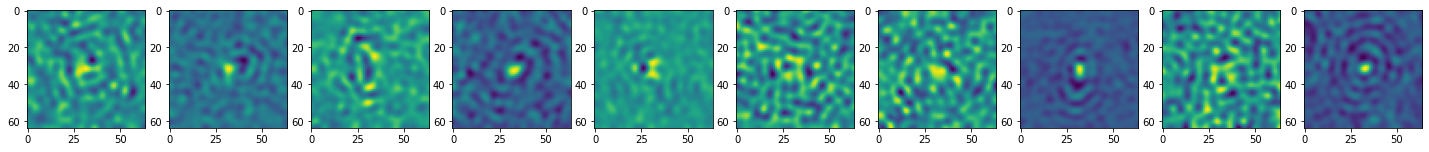

Creating corrected traces 

100%|██████████| 120/120 [00:22<00:00,  5.25it/s]


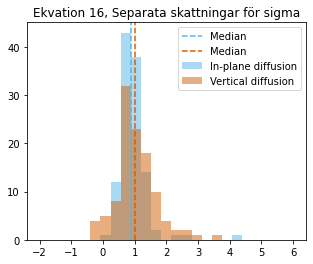

nz/nx = sqrt(Dz/Dx) 1.066


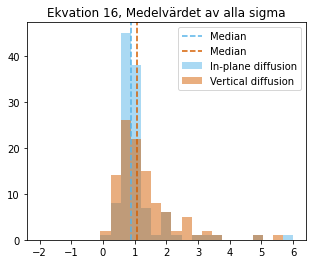

nz/nx = sqrt(Dz/Dx) 1.099
Förväntat förhållande: 1.100
Loading file:
 50wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0.mat 

100%|██████████| 763/763 [00:53<00:00, 14.13it/s]


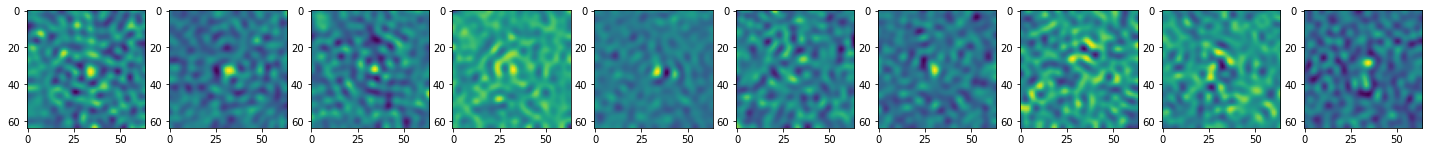

Creating corrected traces 

100%|██████████| 763/763 [02:52<00:00,  4.41it/s]


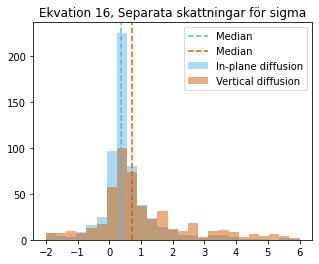

nz/nx = sqrt(Dz/Dx) 1.398


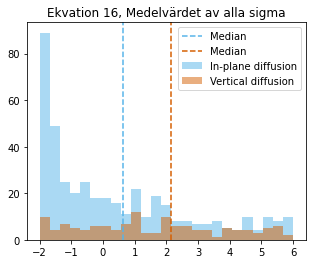

nz/nx = sqrt(Dz/Dx) 1.824
Förväntat förhållande: 1.073
Loading file:
 50wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces.mat 

100%|██████████| 111/111 [00:08<00:00, 12.85it/s]


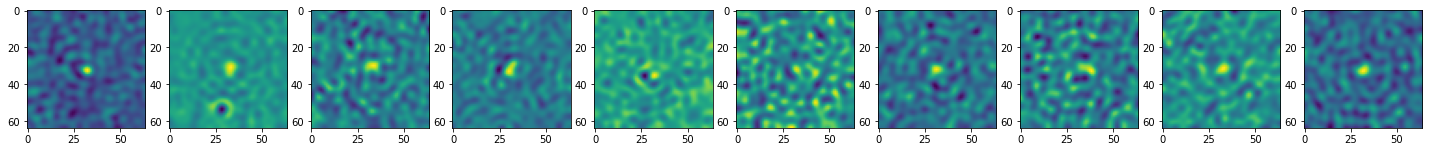

Creating corrected traces 

100%|██████████| 111/111 [00:28<00:00,  3.93it/s]


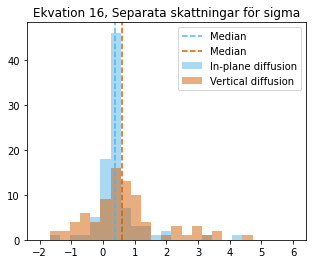

nz/nx = sqrt(Dz/Dx) 1.264


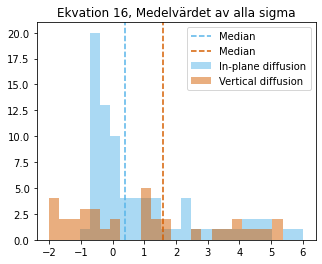

nz/nx = sqrt(Dz/Dx) 2.006
Förväntat förhållande: 1.073


In [16]:
#http://edge.rit.edu/edge/P13051/public/Research%20Notes/refractive%20index%20glycerin%20water.pdf

%matplotlib inline

drive.mount('/content/drive')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

def main():
    weights_path = "/content/drive/My Drive/Saved weights/"
    data_path = "/content/drive/My Drive/ny data från Erik/"
    crop_size = 64
    padding = 16
    wavelength = 525e-9
    pixel_size = 114e-9
    num_outputs=3
    image_size=64
    delta_time = 1/41
    num_layers = 2

    filenames = !ls 'drive/My Drive/ny data från Erik'
    filenames = [filename for filename in filenames if (".mat" in filename and "wGold" in filename)]
    print(f"#Files to process: {len(filenames)}")

    try:
        model = load_weights(weights_path, create_model(CustomLayer(), num_layers, image_size, num_outputs))
        print("WEIGHTS LOADED")
        train_flag = False
    except:
        model = create_model(CustomLayer(), num_layers, image_size, num_outputs)
        print("WEIGHTS NOT LOADED, NEW MODEL CREATED")
        train_flag = True

    for filename in filenames:

        file_path = data_path + filename
        data = scipy.io.loadmat(file_path)['CompletedTraces']

        print(f"Loading file:\n{filename}", end=" ")
        particles_positions, particles_timeseries = extract_pos_and_images(data)

        group, equivariance = create_group(crop_size=crop_size, padding=padding, wavelength=wavelength, pixel_size=pixel_size)
        plot_dataset(create_training_set(particles_timeseries), group, nrows=1)
        if train_flag:
            train_on_particle(model, particles_timeseries, num_outputs, group, equivariance)

        print(f"Creating corrected traces", end=" ")
        traces_matlab, traces_lode, z_mults = compare_lode_matlab(model, particles_timeseries, particles_positions, verbose=0)
        calculate_diffusion([x[0]+x[1] for x in zip(traces_matlab, traces_lode)], delta_time)

        n_glycerin_water = {"0":1.333, "2":1.364, "5": 1.398} #brytningindex för 0, 25 respektive 50 procent glycerin, indexeras med första bokstaven i filnamnet
        print(f"Förväntat förhållande: {1.5/n_glycerin_water[filename[0]]:.3f}")

main()